<a href="https://colab.research.google.com/github/yonghyuk0120/CNN_Study/blob/master/model/Xception(torch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                                                                ↑↑↑↑↑↑
                                        위의 Open in Colab 을 누르면 훨씬 가독성 있게 볼 수 있습니다.

---
# 1. 패키지 로드
---

In [ ]:
!pip install --upgrade albumentations

     |████████████████████████████████| 98 kB 3.1 MB/s 
     |████████████████████████████████| 37.1 MB 72 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import numpy as np
import pandas as pd
import cv2
import sklearn
import albumentations as A
import torch.nn as nn
import math
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from tqdm import tqdm
from torchsummary import summary
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from time import sleep

%matplotlib inline 

#device 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---
# 2. 논문 분석

인셉션 모듈의 연산에 대한 분석 및 개선실험이라고 보면된다.

* 인셉션모듈 분석
* Depthwise Separable Convolution 과의 차이점

---

## 1) 인셉션 모듈분석

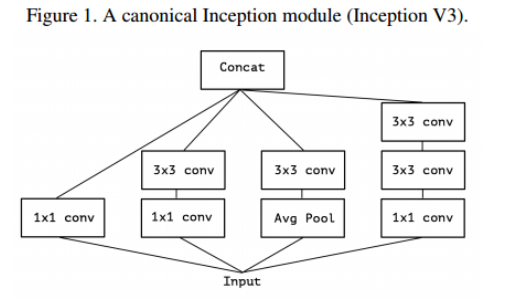

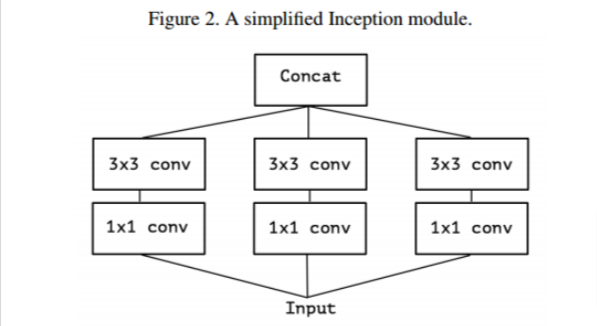

* 원래 사용하던 인셉션 모듈을 간단하게 보면 위와 같이 볼 수 있다. 결국 이 과정은  채널끼리의 상관관계(cross-channel correlations)와 공간적인 상관관계(spatial correlations)를 나눠 수행하는 것이라 볼 수 있다.

* 1x1 coonv가 채널끼리의 상관관계를 계산해주고, 3x3 conv가 공간의 상관관계를 계산해준다.

* 즉, 인셉션 개념의 진정한 가설은 conv과정에서 맵핑을 한번에 하는 것 보다 위와 같이 채널과 공간의 개념으로 나누어하는 것이 더 좋다는 것이다. 그렇다면 이 가설을 더 강력하고 합리적으로 만들 수 있게 더 확실하게 분리 맵핑 할 수 있지않을까

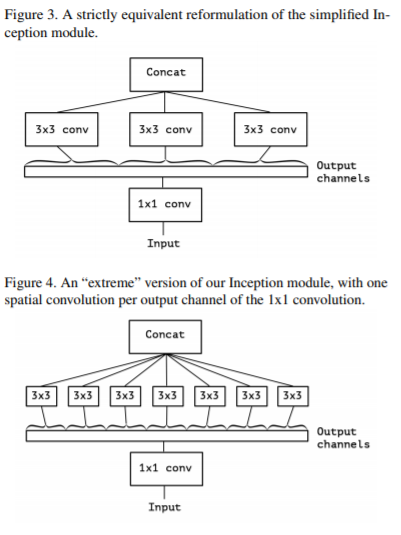

* 이런 관점에서 보면, 간단화된 인셉션 모듈은 그림3 과 같이 변할 수 있고, 이걸 극단적(extream)인 버전으로 표현하면 그림 4와 같다.

* 이 extream 버전은 a depthwise convolution(a spatial convolution)과 pointwise convolution(a 1x1 convolution)으로 구성된 separable convolution(Depthwise Separable Convolutions)랑 비슷하다.

* 이 때, a spatially separable convolution 과 구분해야 한다고 설명한다. 이 또한 separable convolution로 불리기 때문

        용어를 사람들이 혼재해서 쓰기 때문에
        용어를 볼 때마다 의미 파악이 필요하다.

> Spatially Separable Convolution은 3x3연산을 3x1, 1x3으로 나눠서 하는 것들을 의미

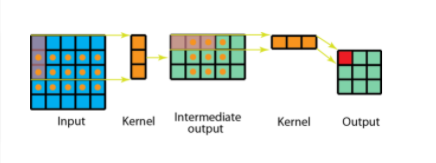

## 2) Depthwise Separable Convolution 과의 차이점

* 1. DSC는 channel-wise spatial convolution 을 먼저 하고, 1x1 conv를 하지만, extreme inception은 그 순서를 다르게한다.
* 2. inception에서는 둘다 ReLU를 쓰는데, 보통 DSC는 중간에 ReLU를 안 쓴다.


    이부분 이해가 잘 되지 않는다.
    이 논문에서 언급된 mobilenet도 두 단계 모두 ReLU가 들어가 있는데,
    왜 잘 쓰지 않는다고 이야기하는지 모르겠다.
    4.7 파트에서 dsc에 ReLU가 들어가야한다고 하면서 여러 실험들을 진행하는데,
    결과 적으로 중간에 아무 것도 없는 것이 가장 성능이 좋았다고한다.

    아래는 원문






The presence or absence of a non-linearity after the first operation. In Inception, both operations are followed by a ReLU non-linearity, however depthwise separable convolutions are usually implemented without non-linearities. 


* xception과 별개로 4.7에서 이 부분에 대해서 실험을 해보았는데, DSC 중간에 비선형을 넣는 것 보다 안 넣는 것이 성능이 뛰어나다고함. 그 이유는 depthwise convolution은 채널 하나에 대해서만 하는 것이므로 비선형성 함수로 잃는 정보가 많을 거라 예상함. 

이에 대해서 아래 부분에 파트에 설명이 있다.


> 다만, 논문은 어차피 1x1 이 먼저 나오는 구조이며, 중간에 아무것도 넣지 않고 ReLU를 따로 포함 >>> 원문.In the experiments reported so far, no such non-linearity was included.


---


# 3. 구현




---







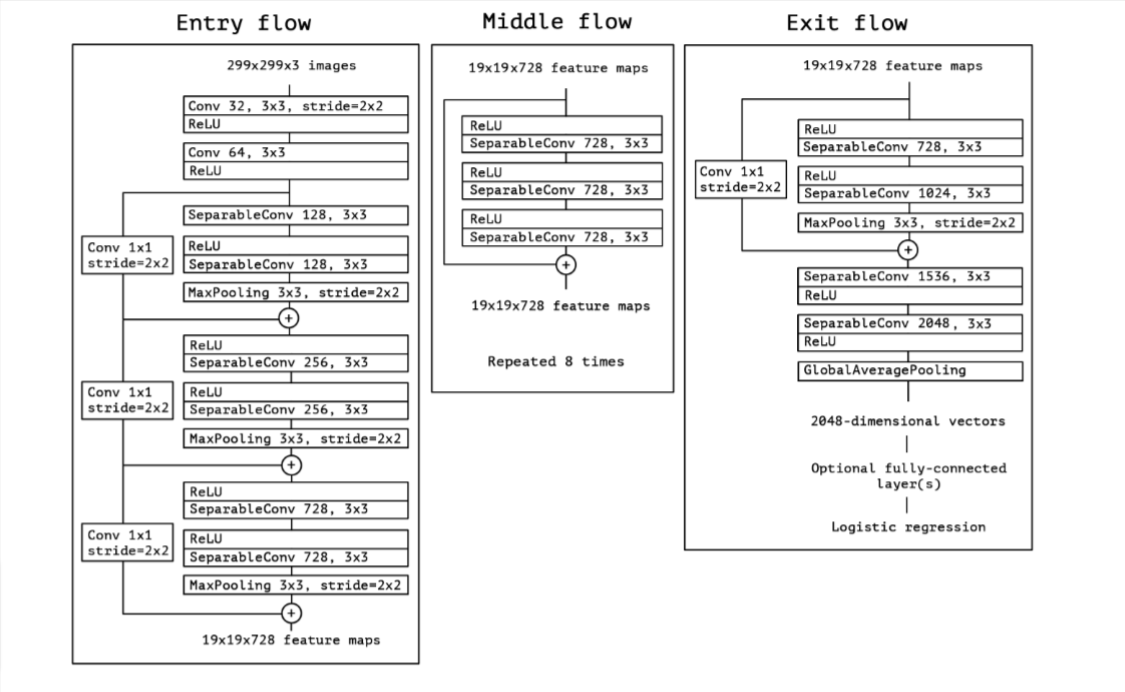

## 기본구조 구현

In [ ]:
def conv_block(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1 , **kwargs) :
    """ 
    conv들이 기본적으로 ReLU를 가지고 있고,
    성능향상을 위해서 BN층도 추가하여 block으로 만든다.
    BN을 사용하므로 bias는 False로 둔다.
    """
    output = nn.Sequential(
       nn.Conv2d(in_channels, out_channels, kernel_size ,stride, padding ,bias =False, **kwargs),
       nn.BatchNorm2d(out_channels),
       nn.ReLU()
    )
    return output

In [ ]:
class xception_block(nn.Module):
    """
    모바일 넷의 Depthwise Separable Convolution와 순서 반대로
    다만 구현 로드맵 + 4.7 설명을 보니  ReLU는 포함하지 않음.(따로 구현)
    """    
    def __init__(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1 , **kwargs) :
        super(xception_block, self).__init__()
        
        # groups = in_channels로 두면 그만큼 나눠서 작동하겠다는 이야기
        # 인채널수와 동일한 값을 넣었으니까 한채널당 1회 연산하여 결과를 내겠다.
        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias = False),
            nn.BatchNorm2d(out_channels)
        )
        
        self.depthwise = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, bias =False ,groups=out_channels),
            nn.BatchNorm2d(out_channels),
        )
        


    def forward(self, x):
        x = self.pointwise(x)
        x = self.depthwise(x)

        return x

#### EntryFlow

In [ ]:
k = torch.zeros((1,3,299,299))
t = nn.Conv2d(3,32,3,2,1)(k)

t.shape

torch.Size([1, 32, 150, 150])

In [ ]:
class EntryFlow(nn.Module):
    def __init__(self):
        super(EntryFlow, self).__init__()    

        self.conv1 = conv_block(3,32, 3, 2,1)
        self.conv2 = conv_block(32,64)

        self.xconv1 = xception_block(64,128)
        self.xconv2 = xception_block(128,128)
        self.pool1 = nn.MaxPool2d(3,2,1)
        
        self.xconv3 = xception_block(128,256)
        self.xconv4 = xception_block(256,256)
        self.pool2 = nn.MaxPool2d(3,2,1)

        self.xconv5 = xception_block(256,728)
        self.xconv6 = xception_block(728,728)
        self.pool3 = nn.MaxPool2d(3,2,1)

        self.id1 = nn.Sequential(
            nn.Conv2d(64,128, 1, 2),
            nn.BatchNorm2d(128)
        )
        
        self.id2 = nn.Sequential(
            nn.Conv2d(128,256, 1, 2),
            nn.BatchNorm2d(256)
        )

        self.id3 = nn.Sequential(
            nn.Conv2d(256,728, 1, 2),
            nn.BatchNorm2d(728)
        )


    def forward(self, input_tensor):
        # xconv는 뒤에 relu가 구현되어있지 않음.
        # 아마 shortcut관련 구현 때문에 순서를 섞은듯
        x = self.conv1(input_tensor)        
        x = self.conv2(x)
        id = self.id1(x)
        
        x = self.xconv1(x)
        x = F.relu(x)
        x = self.xconv2(x)
        x = self.pool1(x)
        
        x = id + x
        id = self.id2(x)
        
        x = F.relu(x)
        x = self.xconv3(x)
        x = F.relu(x)
        x = self.xconv4(x)
        x = self.pool2(x)

        x = id + x
        id = self.id3(x)

        x = F.relu(x)
        x = self.xconv5(x)
        x = F.relu(x)
        x = self.xconv6(x)
        x = self.pool3(x)

        
        return x + id


#### MiddleFlow

In [ ]:
class MdBlock(nn.Module):
    def __init__(self):
        super(MdBlock, self).__init__()    



        self.xconv1 = xception_block(728,728)
        self.xconv2 = xception_block(728,728)
        self.xconv3 = xception_block(728,728)                

        self.id1 = nn.Sequential(
            nn.Conv2d(728,728, 1),
            nn.BatchNorm2d(728)
        )


    def forward(self, input_tensor):
        # xconv는 뒤에 relu가 구현되어있지 않음.
        # 아마 shortcut관련 구현 때문에 순서를 섞은듯
        id = self.id1(input_tensor)
        x = F.relu(input_tensor)
        x = self.xconv1(x)
        x = F.relu(x)
        x = self.xconv2(x)
        x = F.relu(x)
        x = self.xconv3(x)

                
        return x + id


In [ ]:
class MiddleFlow(nn.Module):
    def __init__(self):
        super(MiddleFlow, self).__init__()    

        self.block1 = MdBlock()
        self.block2 = MdBlock()
        self.block3 = MdBlock()
        self.block4 = MdBlock()
        self.block5 = MdBlock()
        self.block6 = MdBlock()
        self.block7 = MdBlock()
        self.block8 = MdBlock()


    def forward(self, input_tensor):
        x = self.block1(input_tensor)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
                
        return x


#### ExitFlow

In [ ]:
class ExitFlow(nn.Module):
    def __init__(self, num_classes =1000):
        super(ExitFlow, self).__init__()    

        self.xconv1 = xception_block(728,728)
        self.xconv2 = xception_block(728,1024)
        self.pool1 = nn.MaxPool2d(3,2,1)
        self.xconv3 = xception_block(1024,1536)
        self.xconv4 = xception_block(1536,2048)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(2048, num_classes)
        )

        self.id1 = nn.Sequential(
            nn.Conv2d(728,1024, 1, 2),
            nn.BatchNorm2d(1024)
        )        


    def forward(self, input_tensor):
        id = self.id1(input_tensor)
        x = F.relu(input_tensor)
        x = self.xconv1(x)
        x = F.relu(x)
        x = self.xconv2(x)
        x = self.pool1(x)

        x = self.xconv3(x+id)
        x = F.relu(x)
        x = self.xconv4(x)
        x = F.relu(x)

        x = self.classifier(x)


                
        return x


## Xception 구현

In [ ]:
class Xception(nn.Module):
    def __init__(self, num_classes=1000):
        super(Xception, self).__init__()    

        self.entry = EntryFlow()
        self.middle = MiddleFlow()
        self.exit1 = ExitFlow(10)
        self._initialize_weights()

    


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)



    def forward(self, input_tensor):
        x = self.entry(input_tensor)
        x = self.middle(x)
        x = self.exit1(x)

        return x



---
# 4. 데이터 전처리
---

## 데이터 로드
 * 이미지 채크
 * STL10 (3,96,96)의 토치형식


In [ ]:
trainset = torchvision.datasets.STL10(root='./data', split='test',
                                        download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.STL10(root='./data', split='train',
                                       download=True, transform= transforms.ToTensor())

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
classes = trainset.classes

In [ ]:
batch_size = 7
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
classes = trainset.classes
# 클래스 정보 가져오기

In [ ]:
# trainloader.

In [ ]:
# 이미지를 보여주기 위한 함수
def show_images(images, labels, ncols=4):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(np.transpose(images[i], (1, 2, 0)))
        # 차원이 바뀌므로 바꿔줘야함
        axs[i].set_title(classes[labels[i]])

In [ ]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [ ]:
labels.shape

torch.Size([7])

(3, 96, 96)
torch.Size([3, 96, 96])


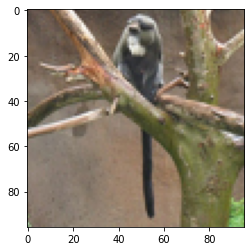

In [ ]:
# 잘 들어왔나 확인
# plt.imshow(trainset.data[1])
# STL은 애초에 데이터셋 자체가 텐서형식임((3, 96, 96))
# Totensor(데이터 로더를 통해)하면 알아서 차원까지 transpose해줌.
# cifar 경우 32 32 3 임. plt가 32,32,3 으로 받기 때문에 plt 통해 출력하려면 transpose가 필요
plt.imshow(np.transpose(trainset.data[1], (1, 2, 0)))

print(trainset.data[1].shape)
print(images[1].shape)

In [ ]:
print(trainset.data[1][1,:3,0:3])
print(images[1][1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1]/255)[1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1])[1,:3,0:3])
# trainloader의 trasform을 거치는 것 만으로 0~1로 정규화된다.
# 아래 transform에서 평균과 표준편차로 나누는 것은 정확히는 표준화이다.
# totensor를 거치면 자동으로 0~1로 정규화 된다. 그리고 totensor 안에 transpose도 들어있는듯
# totensor안에 정규화가 들어있는데, 값이 이미 정규화되어있으면 하지 않음. 3,4번 라인비교


[[73 81 89]
 [71 79 86]
 [64 77 80]]
tensor([[0.2863, 0.3176, 0.3490],
        [0.2784, 0.3098, 0.3373],
        [0.2510, 0.3020, 0.3137]])
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]], dtype=torch.float64)
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]])


In [ ]:
# 아래처럼, loader안에 transpose 후 totensor하면 원하던 차원순서 312가 나옴
testnp = np.zeros((3,1,2))
print(testnp.shape)
print(transforms.ToTensor()(testnp).shape)
print(np.transpose(testnp, (1, 2, 0)).shape)
print(transforms.ToTensor()(np.transpose(testnp, (1, 2, 0))).shape)

(3, 1, 2)
torch.Size([2, 3, 1])
(1, 2, 3)
torch.Size([3, 1, 2])


In [ ]:
print(trainset.data[1].shape)
print(images[1].shape)
print(transforms.ToTensor()(trainset.data[1]).shape)

# totansor뿐만아니라 loader까지 거쳐야 원하는 차원으로 나오는듯
# 아마 로더에 차원 변경이 구현되어있는듯
# 아래 커스텀 모델에 이것도 구현해야함.

(3, 96, 96)
torch.Size([3, 96, 96])
torch.Size([96, 3, 96])


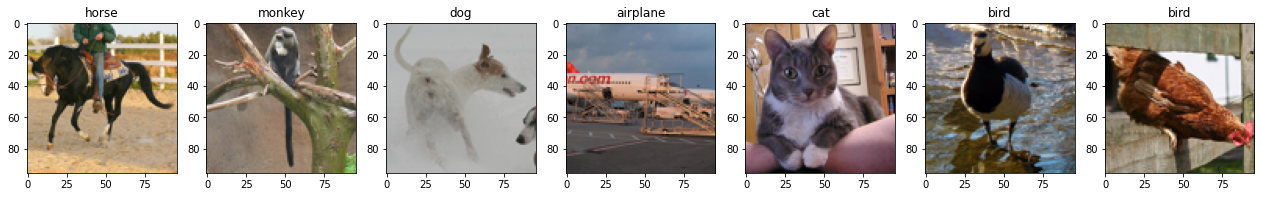

In [ ]:
# 이미지 보여주기
show_images(images,labels,7)

In [ ]:
images[1][1,1,1]

tensor(0.3098)

In [ ]:
aa = np.transpose(trainset.data[1], (1, 2, 0))
print(transforms.ToTensor()(aa).shape)

torch.Size([3, 96, 96])


## 커스텀 데이터셋 구현
* albumentations을 사용하기 위해서 커스텀 데이터 셋을 구현한다.
* 파이토치 텐서플로우 전부 이미지를 배치단위로 cpu,gpu 옮기는 과정에 병목이 있다고 알고있음. 즉, tf나 torch나 데이터 파이프 라인을 그대로 쓰는 것 보다 albumentations을 이용하는 것이 훨씬빠름.




In [ ]:
# 커스텀 데이터(albumenatation 적용)
class ForAlbuSet(Dataset):
    def __init__(self, dataset, transform = None ,data_type = "train" ):
        self.dataset = dataset
        self.transform = transform
        self.data_type = data_type


    def __len__(self):
        return self.dataset.data.shape[0]

    def __getitem__(self, index):
        image = self.dataset.data[index]
        image = np.transpose(image, (1, 2, 0))
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 위옵션은 cv2.imread에서 필요함
        label = self.dataset.labels[index]
        # CIFAR에서는 데이터셋 안에 label이 아니라 target으로 적혀있음.
        # CIFAR는 int반환이지만 얘는 numpy.unit8
        # label과 image를 output 결과와 통일 시켜야함(int,long, float, double 등등)
        # 형변환은 train에서 구현 : 데이터셋과 상관없이 항상 필요한 작업

        
        if self.data_type == "train" : 
            # random_n = np.random.randint(148,256)
            # image = cv2.resize(image, (random_n,random_n))
            # resize로 멀티스케일을 작게나마 구현 해보았음
            # 다만 너무 계산시간이 커진다.


            if self.transform is not None:
                image = self.transform(image=image)["image"]        
        else :

            if self.transform is not None:
                image = self.transform(image=image)["image"]


        return image, label
    

## 증강(transform)

* 토치의 transform 사용시에는 to 텐서 다음에 노말 하기. totensor를 해야 값들이 0\~1사이로감. 그래야 imagenet 평균과 표준편차를 사용가능(0\~255가 아니라 0~1이니까)
    > albumentation은 구현코드를 확인해보면, normalize안에 자동으로 255로 나눠서 구현되어있음.


* torchvision.transforms.(채널, 세로, 가로) 과 달리 Albu.transforms 는 array 기준으로 작업함(세로,가로,채널)
* cv2는 (가로,세로,채널)

* (주의) totensor없으면 loader가 작동 안 함.(차원 순서 바뀌기 때문)

* 실험과정에서 성능이 좋지않아서 논문과 다른 장치들을 넣었음.

In [ ]:
augmentor_tr = A.Compose([        
    # A.Resize(232,232),
    # A.Resize(224,224),                
    # A.FancyPCA(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.5, rotate_limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
    A.Blur(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

augmentor_test = A.Compose([
    # A.Resize(224,224),                            
    A.Normalize(),
    ToTensorV2()
])

## 분할

* random_split이 Torch.utils.data.dataset.random_split에도 있는데, 이건 제대로 작동 안 하니까 조심, random_split은 분할을 하지만 원본을 그대로 두고 랜덤인덱스로 불러오는 원리.아마 메모리 관리를 위해 이렇게 구현한듯

* STL10 데이터는 테스트가 8000개고 트레인이 5000개 이다. 테스트가 트레인보다 많으므로, test데이터로 train에쓰고 train 데이터로 테스트에 쓰자. 트레인 데이터가 더 많아야 한다. 
    > 위의 로딩식 수정했음. 
    
* 또한 분할을 이용해서 5000개를 3000/2000으로 나누어 validation과 test를 하자.

In [ ]:
val_ratio = 0.6
val_size = round(len(testset)*val_ratio)
test_size = len(testset) - val_size
                    
val_set, test_set= random_split(
    testset,
    [val_size,test_size],
    generator=torch.Generator().manual_seed(20)
    )

In [ ]:
# 분할 채크
len(val_set)

3000

In [ ]:
ab_train_set = ForAlbuSet(trainset, transform=augmentor_tr)
ab_val_set = ForAlbuSet(val_set.dataset, transform=augmentor_test, data_type= 'val')
ab_test_set = ForAlbuSet(test_set.dataset, transform=augmentor_test, data_type= 'test')


In [ ]:
batch_size = 64
train_loader = DataLoader(ab_train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_loader = DataLoader(ab_val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

test_loader = DataLoader(ab_test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)




---
# 5. 학습 및 평가
---

**구현목표**
* 정확도 metric 구현 
* 로스, 정확도 동시에 출력
* 콜백(reducelr, earlystop)
* 작업진행도 모니터링 출력
* 테스트 loss 변화 그래프로 출력
* train, vaildate, fit 구현



## early stopping class 정의

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0

        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')

        self.val_loss_min = val_loss

## train, validate, fit, test 함수 정의

In [ ]:
def train(model,train_loader, criterion, optimizer, epoch):
    model.train()
    stream = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for images, target in stream:
        images = images.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()

        output = model(images)
        sum_loss = criterion(output, target)
        loss = sum_loss/len(target)
        # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
        # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 sum이용.



        loss.backward()
        optimizer.step()

        # 로스합
        train_loss +=sum_loss.item()

        # 정확도 계산
        pred = output.max(dim = 1,keepdim = True)[1]
        correct += (target.view(-1, 1) == pred).sum().item()


        stream.set_description(
            f"Epoch: {epoch}. Train."
        )
        

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)

    return train_loss, train_accuracy

In [ ]:
def validate(model, val_loader, criterion, epoch):
    model.eval()
    stream = tqdm(val_loader)
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for images, target in stream:
            images = images.to(device).float()
            target = target.to(device).long()

            output = model(images)
            sum_loss = criterion(output, target)
            loss = sum_loss/len(target)
            # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
            # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 sum이용.

            # 로스합
            val_loss +=sum_loss.item()

            # 정확도 계산
            pred = output.max(dim = 1,keepdim = True)[1]
            correct += (target.view(-1, 1) == pred).sum().item()




            stream.set_description(
                f"Epoch: {epoch}. Validate."
            )
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100. * correct / len(val_loader.dataset)

    return val_loss, val_accuracy

In [ ]:
def fit(model,train_loader,val_loader,criterion,optimizer,epoch, early_stopping=None, scheduler=None):
 
    # epoch당 average loss를 track하기 위한 list
    avg_train_losses = []
    avg_val_losses = []
    avg_train_accuracy = []
    avg_val_accuracy = []

    for i in range(1, epoch + 1):
        train_loss ,train_accuracy =train( model,train_loader, criterion, optimizer, i)
        print(f"[{i}] Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        val_loss ,val_accuracy = validate( model,val_loader, criterion, i)
        if i == epoch :
            sleep(0.1)
            # 마지막 출력에서 tqdm이 업데이트 되기전에 아래 출력값이 나오지 않도록.
            # 다른 줄에 아래값이 나올 수 있게 해줌
        print(f"[{i}] Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")


        
        if scheduler is not None :
            # scheduler.step()
            scheduler.step(val_loss) 
            # 아래는 reducelronplateau 전용
            

        avg_train_losses.append(train_loss)
        avg_val_losses.append(val_loss)
        avg_train_accuracy.append(train_accuracy)
        avg_val_accuracy.append(val_accuracy)

        
        if early_stopping is not None :
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print()
                print("Early stopping")
                sleep(0.1)
                break

        print()

                         
    return  model, avg_train_losses, avg_val_losses,  avg_train_accuracy , avg_val_accuracy


In [ ]:
def test(model, test_loader, criterion):
    test_loss ,test_accuracy = validate( model,test_loader, criterion, 1)
    sleep(0.1)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")
    
    return (test_loss ,test_accuracy)

## 학습

In [ ]:
model = Xception(10).to(device)

In [ ]:
# loss function의 정의(CrossEntropyLoss)
criterion = nn.CrossEntropyLoss(reduction='sum')


# optimizer 정의
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# 스케쥴러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


# early_stopping
early_stopping = EarlyStopping(patience = 15, verbose = True)

In [ ]:
# 메모리가 계속 부족해서 논문과 달리 이미지를 299 >> 96으로 줄임
# 메모리가 계속 부족해서 배치사이즈를 줄임
model, train_loss, val_loss ,train_accuracy ,val_accuracy= fit(model,train_loader,val_loader,criterion,optimizer,100,early_stopping,scheduler)

  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch: 1. Train.: 100%|██████████| 125/125 [01:37<00:00,  1.28it/s]


[1] Train Loss: 2.2216, Accuracy: 15.46%


Epoch: 1. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


[1] Validation Loss: 2.0600, Accuracy: 21.70%
Validation loss decreased (inf --> 2.059976).



Epoch: 2. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[2] Train Loss: 1.9044, Accuracy: 25.57%


Epoch: 2. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


[2] Validation Loss: 1.7808, Accuracy: 29.88%
Validation loss decreased (2.059976 --> 1.780776).



Epoch: 3. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[3] Train Loss: 1.8259, Accuracy: 29.14%


Epoch: 3. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


[3] Validation Loss: 1.7262, Accuracy: 32.78%
Validation loss decreased (1.780776 --> 1.726203).



Epoch: 4. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[4] Train Loss: 1.7781, Accuracy: 30.76%


Epoch: 4. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


[4] Validation Loss: 1.9134, Accuracy: 28.96%
EarlyStopping counter: 1 out of 15



Epoch: 5. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[5] Train Loss: 1.7116, Accuracy: 33.30%


Epoch: 5. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


[5] Validation Loss: 1.5645, Accuracy: 40.54%
Validation loss decreased (1.726203 --> 1.564490).



Epoch: 6. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[6] Train Loss: 1.6728, Accuracy: 36.51%


Epoch: 6. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


[6] Validation Loss: 1.5026, Accuracy: 42.92%
Validation loss decreased (1.564490 --> 1.502595).



Epoch: 7. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[7] Train Loss: 1.6298, Accuracy: 38.09%


Epoch: 7. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


[7] Validation Loss: 1.5530, Accuracy: 40.92%
EarlyStopping counter: 1 out of 15



Epoch: 8. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[8] Train Loss: 1.6003, Accuracy: 39.31%


Epoch: 8. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


[8] Validation Loss: 1.4787, Accuracy: 45.22%
Validation loss decreased (1.502595 --> 1.478665).



Epoch: 9. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[9] Train Loss: 1.5650, Accuracy: 40.67%


Epoch: 9. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


[9] Validation Loss: 1.3987, Accuracy: 48.24%
Validation loss decreased (1.478665 --> 1.398688).



Epoch: 10. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[10] Train Loss: 1.5289, Accuracy: 42.27%


Epoch: 10. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


[10] Validation Loss: 1.3646, Accuracy: 48.90%
Validation loss decreased (1.398688 --> 1.364615).



Epoch: 11. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[11] Train Loss: 1.4888, Accuracy: 44.08%


Epoch: 11. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


[11] Validation Loss: 1.3237, Accuracy: 50.72%
Validation loss decreased (1.364615 --> 1.323656).



Epoch: 12. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[12] Train Loss: 1.4764, Accuracy: 45.60%


Epoch: 12. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


[12] Validation Loss: 1.3714, Accuracy: 50.28%
EarlyStopping counter: 1 out of 15



Epoch: 13. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[13] Train Loss: 1.4543, Accuracy: 46.55%


Epoch: 13. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


[13] Validation Loss: 1.3465, Accuracy: 50.22%
EarlyStopping counter: 2 out of 15



Epoch: 14. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[14] Train Loss: 1.4126, Accuracy: 47.62%


Epoch: 14. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


[14] Validation Loss: 1.2316, Accuracy: 54.40%
Validation loss decreased (1.323656 --> 1.231564).



Epoch: 15. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[15] Train Loss: 1.3989, Accuracy: 48.61%


Epoch: 15. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


[15] Validation Loss: 1.2822, Accuracy: 53.48%
EarlyStopping counter: 1 out of 15



Epoch: 16. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[16] Train Loss: 1.3722, Accuracy: 49.11%


Epoch: 16. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


[16] Validation Loss: 1.2189, Accuracy: 55.14%
Validation loss decreased (1.231564 --> 1.218923).



Epoch: 17. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[17] Train Loss: 1.3537, Accuracy: 50.36%


Epoch: 17. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


[17] Validation Loss: 1.2226, Accuracy: 55.28%
EarlyStopping counter: 1 out of 15



Epoch: 18. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[18] Train Loss: 1.3570, Accuracy: 49.73%


Epoch: 18. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


[18] Validation Loss: 1.3463, Accuracy: 52.60%
EarlyStopping counter: 2 out of 15



Epoch: 19. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[19] Train Loss: 1.3183, Accuracy: 51.84%


Epoch: 19. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


[19] Validation Loss: 1.3080, Accuracy: 53.04%
EarlyStopping counter: 3 out of 15



Epoch: 20. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[20] Train Loss: 1.2955, Accuracy: 52.36%


Epoch: 20. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


[20] Validation Loss: 1.1896, Accuracy: 57.06%
Validation loss decreased (1.218923 --> 1.189633).



Epoch: 21. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[21] Train Loss: 1.2896, Accuracy: 52.79%


Epoch: 21. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


[21] Validation Loss: 1.1420, Accuracy: 58.68%
Validation loss decreased (1.189633 --> 1.141977).



Epoch: 22. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[22] Train Loss: 1.2741, Accuracy: 53.52%


Epoch: 22. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


[22] Validation Loss: 1.1564, Accuracy: 58.86%
EarlyStopping counter: 1 out of 15



Epoch: 23. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[23] Train Loss: 1.2475, Accuracy: 54.17%


Epoch: 23. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


[23] Validation Loss: 1.1650, Accuracy: 57.28%
EarlyStopping counter: 2 out of 15



Epoch: 24. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[24] Train Loss: 1.2201, Accuracy: 56.27%


Epoch: 24. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


[24] Validation Loss: 1.2579, Accuracy: 54.86%
EarlyStopping counter: 3 out of 15



Epoch: 25. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[25] Train Loss: 1.2153, Accuracy: 56.05%


Epoch: 25. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


[25] Validation Loss: 1.1564, Accuracy: 57.48%
EarlyStopping counter: 4 out of 15



Epoch: 26. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[26] Train Loss: 1.2093, Accuracy: 55.99%


Epoch: 26. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


[26] Validation Loss: 1.0801, Accuracy: 60.70%
Validation loss decreased (1.141977 --> 1.080099).



Epoch: 27. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[27] Train Loss: 1.2007, Accuracy: 56.39%


Epoch: 27. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


[27] Validation Loss: 1.1151, Accuracy: 58.98%
EarlyStopping counter: 1 out of 15



Epoch: 28. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[28] Train Loss: 1.1715, Accuracy: 57.02%


Epoch: 28. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


[28] Validation Loss: 1.1100, Accuracy: 59.42%
EarlyStopping counter: 2 out of 15



Epoch: 29. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[29] Train Loss: 1.1621, Accuracy: 58.34%


Epoch: 29. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


[29] Validation Loss: 1.1877, Accuracy: 58.76%
EarlyStopping counter: 3 out of 15



Epoch: 30. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[30] Train Loss: 1.1319, Accuracy: 58.90%


Epoch: 30. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


[30] Validation Loss: 1.1510, Accuracy: 58.02%
EarlyStopping counter: 4 out of 15



Epoch: 31. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[31] Train Loss: 1.1228, Accuracy: 59.61%


Epoch: 31. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


[31] Validation Loss: 1.0363, Accuracy: 62.44%
Validation loss decreased (1.080099 --> 1.036345).



Epoch: 32. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[32] Train Loss: 1.1186, Accuracy: 59.95%


Epoch: 32. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


[32] Validation Loss: 1.0761, Accuracy: 61.30%
EarlyStopping counter: 1 out of 15



Epoch: 33. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[33] Train Loss: 1.0983, Accuracy: 60.81%


Epoch: 33. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


[33] Validation Loss: 1.0808, Accuracy: 61.32%
EarlyStopping counter: 2 out of 15



Epoch: 34. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[34] Train Loss: 1.0955, Accuracy: 60.40%


Epoch: 34. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


[34] Validation Loss: 1.0949, Accuracy: 60.86%
EarlyStopping counter: 3 out of 15



Epoch: 35. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[35] Train Loss: 1.0502, Accuracy: 61.89%


Epoch: 35. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


[35] Validation Loss: 1.1259, Accuracy: 60.34%
EarlyStopping counter: 4 out of 15



Epoch: 36. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[36] Train Loss: 1.0432, Accuracy: 62.08%


Epoch: 36. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


[36] Validation Loss: 1.1660, Accuracy: 58.52%
EarlyStopping counter: 5 out of 15



Epoch: 37. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[37] Train Loss: 1.0532, Accuracy: 62.49%


Epoch: 37. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


[37] Validation Loss: 1.0015, Accuracy: 63.44%
Validation loss decreased (1.036345 --> 1.001455).



Epoch: 38. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[38] Train Loss: 1.0396, Accuracy: 62.74%


Epoch: 38. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s]


[38] Validation Loss: 1.2537, Accuracy: 56.56%
EarlyStopping counter: 1 out of 15



Epoch: 39. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[39] Train Loss: 1.0254, Accuracy: 62.99%


Epoch: 39. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


[39] Validation Loss: 1.0152, Accuracy: 63.46%
EarlyStopping counter: 2 out of 15



Epoch: 40. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[40] Train Loss: 1.0105, Accuracy: 63.75%


Epoch: 40. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


[40] Validation Loss: 1.0185, Accuracy: 64.02%
EarlyStopping counter: 3 out of 15



Epoch: 41. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[41] Train Loss: 0.9981, Accuracy: 64.34%


Epoch: 41. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


[41] Validation Loss: 1.0512, Accuracy: 62.52%
EarlyStopping counter: 4 out of 15



Epoch: 42. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[42] Train Loss: 0.9776, Accuracy: 65.12%


Epoch: 42. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


[42] Validation Loss: 1.0666, Accuracy: 62.04%
EarlyStopping counter: 5 out of 15



Epoch: 43. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[43] Train Loss: 0.9824, Accuracy: 64.95%


Epoch: 43. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


[43] Validation Loss: 1.1592, Accuracy: 60.92%
EarlyStopping counter: 6 out of 15



Epoch: 44. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[44] Train Loss: 0.9549, Accuracy: 65.84%


Epoch: 44. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


[44] Validation Loss: 1.0028, Accuracy: 64.22%
EarlyStopping counter: 7 out of 15



Epoch: 45. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[45] Train Loss: 0.9352, Accuracy: 66.76%


Epoch: 45. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


[45] Validation Loss: 1.1741, Accuracy: 60.98%
EarlyStopping counter: 8 out of 15



Epoch: 46. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[46] Train Loss: 0.9363, Accuracy: 66.78%


Epoch: 46. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


[46] Validation Loss: 1.0484, Accuracy: 63.28%
EarlyStopping counter: 9 out of 15



Epoch: 47. Train.: 100%|██████████| 125/125 [01:37<00:00,  1.29it/s]


[47] Train Loss: 0.9060, Accuracy: 68.01%


Epoch: 47. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


[47] Validation Loss: 1.0189, Accuracy: 65.08%
EarlyStopping counter: 10 out of 15



Epoch: 48. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[48] Train Loss: 0.9044, Accuracy: 67.71%


Epoch: 48. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


[48] Validation Loss: 1.0969, Accuracy: 63.06%
Epoch    48: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 11 out of 15



Epoch: 49. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[49] Train Loss: 0.8436, Accuracy: 70.14%


Epoch: 49. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


[49] Validation Loss: 0.9418, Accuracy: 67.24%
Validation loss decreased (1.001455 --> 0.941778).



Epoch: 50. Train.: 100%|██████████| 125/125 [01:37<00:00,  1.29it/s]


[50] Train Loss: 0.7967, Accuracy: 71.75%


Epoch: 50. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


[50] Validation Loss: 0.9267, Accuracy: 67.72%
Validation loss decreased (0.941778 --> 0.926721).



Epoch: 51. Train.: 100%|██████████| 125/125 [01:37<00:00,  1.29it/s]


[51] Train Loss: 0.7605, Accuracy: 73.28%


Epoch: 51. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s]


[51] Validation Loss: 0.9187, Accuracy: 67.88%
Validation loss decreased (0.926721 --> 0.918677).



Epoch: 52. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[52] Train Loss: 0.7650, Accuracy: 72.71%


Epoch: 52. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


[52] Validation Loss: 0.9168, Accuracy: 68.72%
Validation loss decreased (0.918677 --> 0.916813).



Epoch: 53. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[53] Train Loss: 0.7357, Accuracy: 74.53%


Epoch: 53. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


[53] Validation Loss: 0.9179, Accuracy: 68.22%
EarlyStopping counter: 1 out of 15



Epoch: 54. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[54] Train Loss: 0.7336, Accuracy: 74.10%


Epoch: 54. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


[54] Validation Loss: 0.9087, Accuracy: 68.62%
Validation loss decreased (0.916813 --> 0.908714).



Epoch: 55. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[55] Train Loss: 0.7227, Accuracy: 74.34%


Epoch: 55. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s]


[55] Validation Loss: 0.9161, Accuracy: 68.18%
EarlyStopping counter: 1 out of 15



Epoch: 56. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[56] Train Loss: 0.6984, Accuracy: 75.42%


Epoch: 56. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


[56] Validation Loss: 0.9209, Accuracy: 68.12%
EarlyStopping counter: 2 out of 15



Epoch: 57. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[57] Train Loss: 0.6988, Accuracy: 75.14%


Epoch: 57. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


[57] Validation Loss: 0.9085, Accuracy: 68.80%
Validation loss decreased (0.908714 --> 0.908485).



Epoch: 58. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[58] Train Loss: 0.7087, Accuracy: 75.44%


Epoch: 58. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s]


[58] Validation Loss: 0.9154, Accuracy: 68.22%
EarlyStopping counter: 1 out of 15



Epoch: 59. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[59] Train Loss: 0.6812, Accuracy: 76.30%


Epoch: 59. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


[59] Validation Loss: 0.9275, Accuracy: 68.70%
EarlyStopping counter: 2 out of 15



Epoch: 60. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[60] Train Loss: 0.6909, Accuracy: 75.94%


Epoch: 60. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s]


[60] Validation Loss: 0.9228, Accuracy: 68.66%
EarlyStopping counter: 3 out of 15



Epoch: 61. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[61] Train Loss: 0.6736, Accuracy: 76.50%


Epoch: 61. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.25it/s]


[61] Validation Loss: 0.9157, Accuracy: 68.34%
EarlyStopping counter: 4 out of 15



Epoch: 62. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[62] Train Loss: 0.6690, Accuracy: 76.78%


Epoch: 62. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.25it/s]


[62] Validation Loss: 0.9271, Accuracy: 68.50%
EarlyStopping counter: 5 out of 15



Epoch: 63. Train.: 100%|██████████| 125/125 [01:37<00:00,  1.29it/s]


[63] Train Loss: 0.6517, Accuracy: 77.50%


Epoch: 63. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


[63] Validation Loss: 0.9385, Accuracy: 68.44%
EarlyStopping counter: 6 out of 15



Epoch: 64. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[64] Train Loss: 0.6563, Accuracy: 77.39%


Epoch: 64. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.25it/s]


[64] Validation Loss: 0.9433, Accuracy: 68.30%
EarlyStopping counter: 7 out of 15



Epoch: 65. Train.: 100%|██████████| 125/125 [01:37<00:00,  1.29it/s]


[65] Train Loss: 0.6624, Accuracy: 77.28%


Epoch: 65. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s]


[65] Validation Loss: 0.9484, Accuracy: 68.60%
EarlyStopping counter: 8 out of 15



Epoch: 66. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[66] Train Loss: 0.6416, Accuracy: 77.89%


Epoch: 66. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s]


[66] Validation Loss: 0.9551, Accuracy: 68.46%
EarlyStopping counter: 9 out of 15



Epoch: 67. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[67] Train Loss: 0.6317, Accuracy: 77.90%


Epoch: 67. Validate.: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s]


[67] Validation Loss: 0.9438, Accuracy: 68.44%
EarlyStopping counter: 10 out of 15



Epoch: 68. Train.: 100%|██████████| 125/125 [01:37<00:00,  1.29it/s]


[68] Train Loss: 0.6388, Accuracy: 77.81%


Epoch: 68. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


[68] Validation Loss: 0.9411, Accuracy: 68.40%
Epoch    68: reducing learning rate of group 0 to 1.0000e-06.
EarlyStopping counter: 11 out of 15



Epoch: 69. Train.: 100%|██████████| 125/125 [01:37<00:00,  1.29it/s]


[69] Train Loss: 0.6388, Accuracy: 78.34%


Epoch: 69. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


[69] Validation Loss: 0.9276, Accuracy: 69.12%
EarlyStopping counter: 12 out of 15



Epoch: 70. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[70] Train Loss: 0.6134, Accuracy: 79.09%


Epoch: 70. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


[70] Validation Loss: 0.9276, Accuracy: 68.96%
EarlyStopping counter: 13 out of 15



Epoch: 71. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[71] Train Loss: 0.6089, Accuracy: 78.79%


Epoch: 71. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


[71] Validation Loss: 0.9371, Accuracy: 69.04%
EarlyStopping counter: 14 out of 15



Epoch: 72. Train.: 100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


[72] Train Loss: 0.6181, Accuracy: 78.95%


Epoch: 72. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]

[72] Validation Loss: 0.9351, Accuracy: 69.04%
EarlyStopping counter: 15 out of 15

Early stopping


## 평가

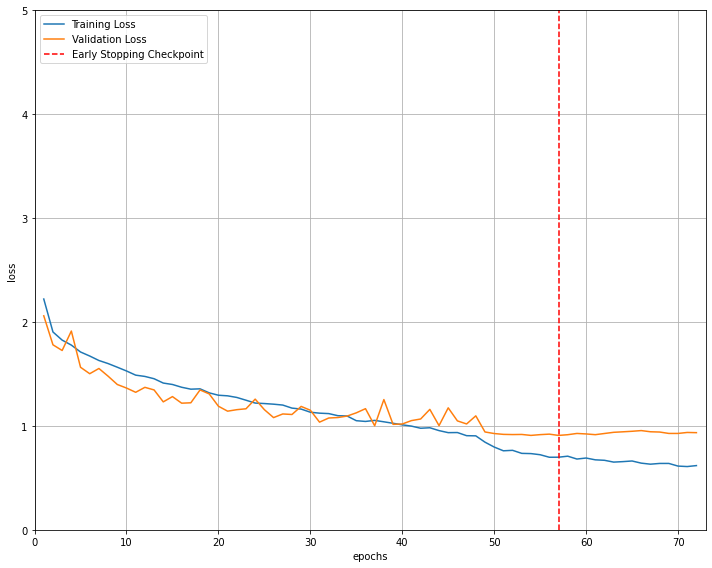

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = val_loss.index(min(val_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 5) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

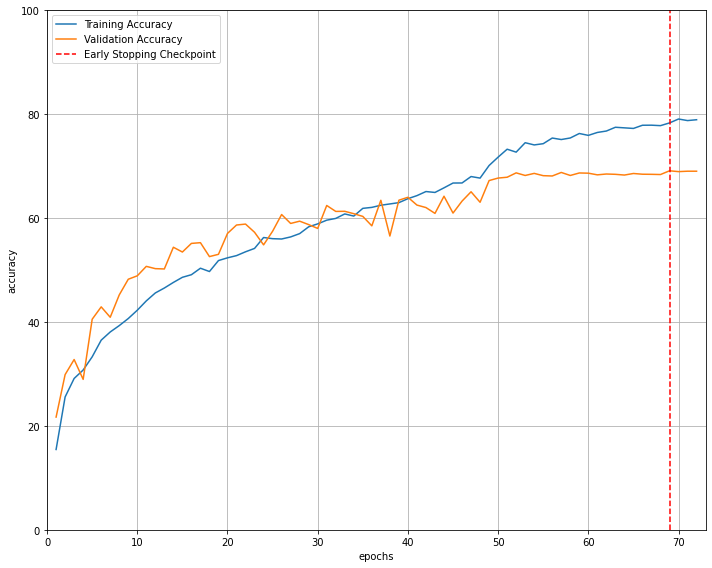

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_accuracy)+1),train_accuracy, label='Training Accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,label='Validation Accuracy')

# validation Accuracy의 최대값 지점을 찾기
maxposs = val_accuracy.index(max(val_accuracy))+1
plt.axvline(maxposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 100) # 일정한 scale
plt.xlim(0, len(train_accuracy)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('accuracy_plot.png', bbox_inches = 'tight')

In [ ]:
test(model, test_loader, criterion)

Epoch: 1. Validate.: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]

Test Loss: 0.9351, Accuracy: 69.04%


(0.9351331653594971, 69.04)